In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply
import re
import json
from datetime import datetime, timedelta
import pytz
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
# Function used to extract x & y value from activity log
def extract_x_value(point_str):
    match = re.search(r'x=(\d+)', point_str)
    if match:
        return int(match.group(1))
    return None

def extract_y_value(point_str):
    match = re.search(r'y=(\d+)', point_str)
    if match:
        return int(match.group(1))
    return None

In [3]:
def read_data_from_file(file_name):
    time_values = []
    temperature_values = []
    pressure_values = []
    altitude_values = []
    humidity_values = []
    light_values = []
    co2_values = []

    with open(file_name, 'r') as file:
        for line in file:
            # Split the line by commas
            values = line.strip().split(',')
            
            # Extract the time value and convert it to seconds
            # Input time value
            time_str = values[0]

            if time_str:
                # Current date or a specific date you want to associate with the time
                date = datetime(2023, 8, 4, 12, 30, 0)  # Year, Month, Day, Hour, Minute, Second
                date = date.date()  # You can replace this with a specific date if needed

                # Parse the input time value and create a datetime object
                time_obj = datetime.strptime(time_str, "%H:%M:%S.%f")

                # Combine the date with the time
                combined_datetime = datetime.combine(date, time_obj.time())
                time_values.append(combined_datetime)

                # Extract other values
                temperature_values.append(float(values[1]))
                pressure_values.append(float(values[2]))
                altitude_values.append(float(values[3]))
                humidity_values.append(float(values[4]))
                light_values.append(float(values[5]))
                co2_values.append(float(values[6]))

    return time_values, temperature_values, pressure_values, altitude_values, humidity_values, light_values, co2_values

In [4]:
#Readin emotion data and do pre-processing
emotion = pd.read_csv("emotion_data.csv")
emotion['Timestamp'] = emotion.Timestamp.apply(lambda x: datetime.fromtimestamp(x).strftime('%m/%d/%Y %H:%M:%S.%f'))

In [5]:
# Readin keyboard activity data and do pre-processing
keyboard = pd.read_csv('activity_log.csv')
keyboard['Timestamp'] = pd.to_datetime(keyboard['Timestamp'], format='%d/%m/%Y, %H:%M:%S.%f')
keyboard['X_Value'] = keyboard['Mouse Position'].apply(extract_x_value)
keyboard['Y_Value'] = keyboard['Mouse Position'].apply(extract_y_value)

In [6]:
# Readin EEG data and do pre-processing
eeg = pd.read_csv("EEG_recording_2023-08-04-19.25.21.csv")
eeg['timestamps_alt'] = eeg.timestamps.apply(lambda x: datetime.fromtimestamp(x).strftime('%m/%d/%Y %H:%M:%S.%f')[:-3])

In [7]:
# Readin posture data
posture = pd.read_csv("posture_changes.csv")

In [8]:
# Read environmental data and do pre-processing
file_name = 'env_data.txt'
time_values, temperature_values, pressure_values, altitude_values, humidity_values, light_values, co2_values = read_data_from_file(file_name)
time_series = pd.Series(time_values)

# Convert to pandas datetime
time_series = pd.to_datetime(time_series)

# Subtract the minimum value from each element and calculate the total seconds
time_values_in_seconds = (time_series - time_series.min()).dt.total_seconds()

In [9]:
# Read in-game data from JSON file
with open('data.json', 'r') as f:
    data_dict = json.load(f)

timestamps = []
kills = []
death = []

# Process the JSON data and extract the relevant information
for timestamp, values in data_dict.items():
    temp_time = pd.to_datetime(float(timestamp), unit='s')
    timestamps.append(temp_time)  # Convert the timestamp to pandas datetime
    kills.append(values['player_kill_other'])
    death.append(values['player_get_killed'])

kill_df = pd.DataFrame({
    'Timestamp': timestamps,
    'Kills': kills
})
death_df = pd.DataFrame({
    'Timestamp': timestamps,
    'Death': death
})

pittsburgh_tz = pytz.timezone('US/Eastern')
kill_df['Timestamp'] = kill_df['Timestamp'].apply(lambda x: pd.Timestamp(x, unit='s', tz='UTC').tz_convert(pittsburgh_tz))
death_df['Timestamp'] = death_df['Timestamp'].apply(lambda x: pd.Timestamp(x, unit='s', tz='UTC').tz_convert(pittsburgh_tz))

In [10]:
eeg

,timestamps,TP9,AF7,AF8,TP10,Right AUX,timestamps_alt
0,1.691177e+09,-26.855,-265.625,-36.621,-23.438,0.0,08/04/2023 15:25:26.707
1,1.691177e+09,-10.742,288.086,-40.527,-4.883,0.0,08/04/2023 15:25:26.710
2,1.691177e+09,-10.254,-695.801,-42.969,-28.809,0.0,08/04/2023 15:25:26.714
3,1.691177e+09,-46.875,-1000.000,-44.434,-48.340,0.0,08/04/2023 15:25:26.718
4,1.691177e+09,-45.898,-574.707,-39.551,-29.785,0.0,08/04/2023 15:25:26.722
...,...,...,...,...,...,...,...
114283,1.691178e+09,-17.578,-197.754,-42.480,-41.504,0.0,08/04/2023 15:32:53.095
114284,1.691178e+09,-12.207,64.453,-34.180,-4.883,0.0,08/04/2023 15:32:53.099
114285,1.691178e+09,-11.230,204.590,-34.668,5.371,0.0,08/04/2023 15:32:53.103
114286,1.691178e+09,-41.016,-170.898,-38.086,-22.461,0.0,08/04/2023 15:32:53.107


In [11]:
# Convert the Timestamp column of the kill and death DataFrame to numeric values in seconds
kill_df['Timestamp'] = (kill_df['Timestamp'] - kill_df['Timestamp'].min()).dt.total_seconds()
death_df['Timestamp'] = (death_df['Timestamp'] - death_df['Timestamp'].min()).dt.total_seconds()
# Convert the Timestamp column of the emotion DataFrame to numeric values in seconds
if isinstance(emotion['Timestamp'].iloc[0], str):
    emotion['Timestamp'] = pd.to_datetime(emotion['Timestamp'])
emotion['Timestamp'] = (emotion['Timestamp'] - emotion['Timestamp'].min()).dt.total_seconds()
if isinstance(eeg['timestamps_alt'].iloc[0], str):
    eeg['timestamps_alt'] = pd.to_datetime(eeg['timestamps_alt'])
eeg['timestamps_alt'] = (eeg['timestamps_alt'] - eeg['timestamps_alt'].min()).dt.total_seconds()

In [12]:
eeg

,timestamps,TP9,AF7,AF8,TP10,Right AUX,timestamps_alt
0,1.691177e+09,-26.855,-265.625,-36.621,-23.438,0.0,0.000
1,1.691177e+09,-10.742,288.086,-40.527,-4.883,0.0,0.003
2,1.691177e+09,-10.254,-695.801,-42.969,-28.809,0.0,0.007
3,1.691177e+09,-46.875,-1000.000,-44.434,-48.340,0.0,0.011
4,1.691177e+09,-45.898,-574.707,-39.551,-29.785,0.0,0.015
...,...,...,...,...,...,...,...
114283,1.691178e+09,-17.578,-197.754,-42.480,-41.504,0.0,446.388
114284,1.691178e+09,-12.207,64.453,-34.180,-4.883,0.0,446.392
114285,1.691178e+09,-11.230,204.590,-34.668,5.371,0.0,446.396
114286,1.691178e+09,-41.016,-170.898,-38.086,-22.461,0.0,446.400


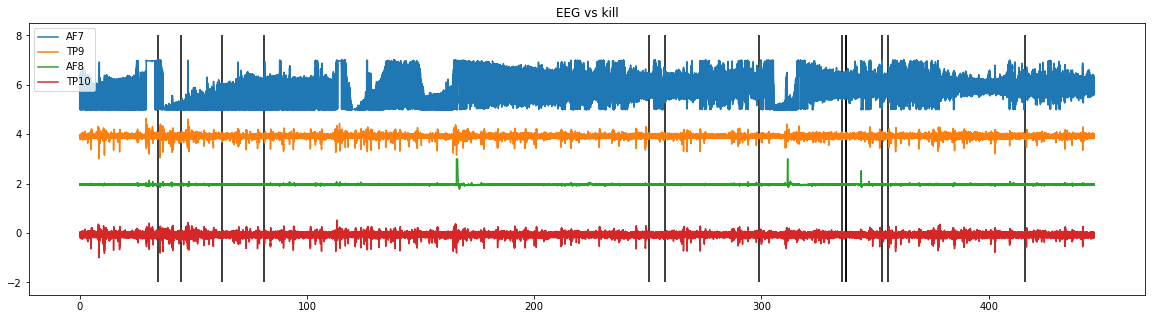

In [13]:
# EEG against kill
y_tp9 = eeg['TP9']
y_af7 = eeg['AF7']
y_af8 = eeg['AF8']
y_tp10 = eeg['TP10']
plt.figure(figsize = (20,5)) 
plt.plot(eeg['timestamps_alt'], y_af7/max(abs(y_af7)) + 6, label = 'AF7')
plt.plot(eeg['timestamps_alt'], y_tp9/max(abs(y_tp9)) + 4, label = 'TP9')
plt.plot(eeg['timestamps_alt'], y_af8/max(abs(y_af8)) + 2, label = 'AF8')
plt.plot(eeg['timestamps_alt'], y_tp10/max(abs(y_tp10)), label = 'TP10')
# Plot vertical lines for kills
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        plt.vlines(timestamp, -2, 8, colors='black')
plt.title("EEG vs kill")
plt.legend()
plt.show()

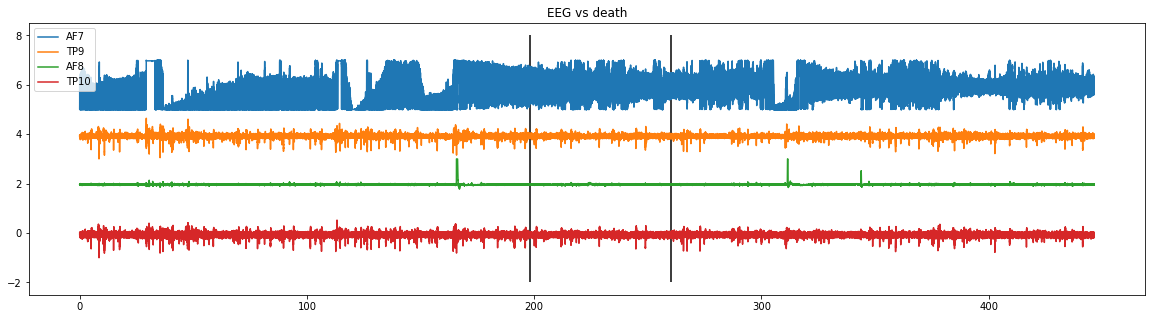

In [14]:
# EEG against death
y_tp9 = eeg['TP9']
y_af7 = eeg['AF7']
y_af8 = eeg['AF8']
y_tp10 = eeg['TP10']
plt.figure(figsize = (20,5)) 
plt.plot(eeg['timestamps_alt'], y_af7/max(abs(y_af7)) + 6, label = 'AF7')
plt.plot(eeg['timestamps_alt'], y_tp9/max(abs(y_tp9)) + 4, label = 'TP9')
plt.plot(eeg['timestamps_alt'], y_af8/max(abs(y_af8)) + 2, label = 'AF8')
plt.plot(eeg['timestamps_alt'], y_tp10/max(abs(y_tp10)), label = 'TP10')
# Plot vertical lines for kills
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        plt.vlines(timestamp, -2, 8, colors='black')
plt.title("EEG vs death")
plt.legend()
plt.show()

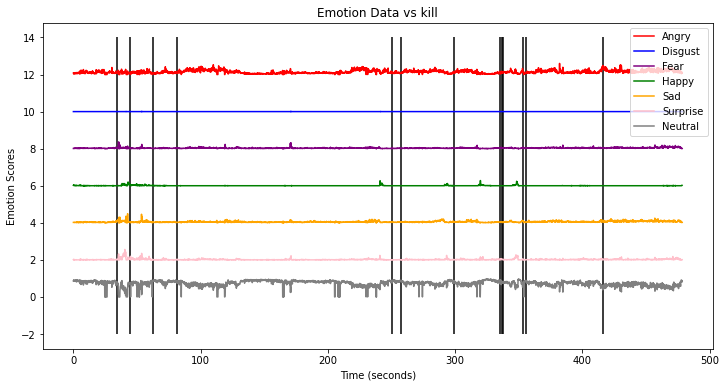

In [15]:
# Plot Emotion data against kill
plt.figure(figsize=(12, 6))
plt.plot(emotion['Timestamp'], emotion['Angry']+12, label='Angry', color='red')
plt.plot(emotion['Timestamp'], emotion['Disgust']+10, label='Disgust', color='blue')
plt.plot(emotion['Timestamp'], emotion['Fear']+8, label='Fear', color='purple')
plt.plot(emotion['Timestamp'], emotion['Happy']+6, label='Happy', color='green')
plt.plot(emotion['Timestamp'], emotion['Sad']+4, label='Sad', color='orange')
plt.plot(emotion['Timestamp'], emotion['Surprise']+2, label='Surprise', color='pink')
plt.plot(emotion['Timestamp'], emotion['Neutral'], label='Neutral', color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Emotion Scores', color='black')
plt.title('Emotion Data vs kill')
plt.legend(loc='upper right')

# Plot vertical lines for kills
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        plt.vlines(timestamp, -2, 14, colors='black')

plt.show()
plt.close()

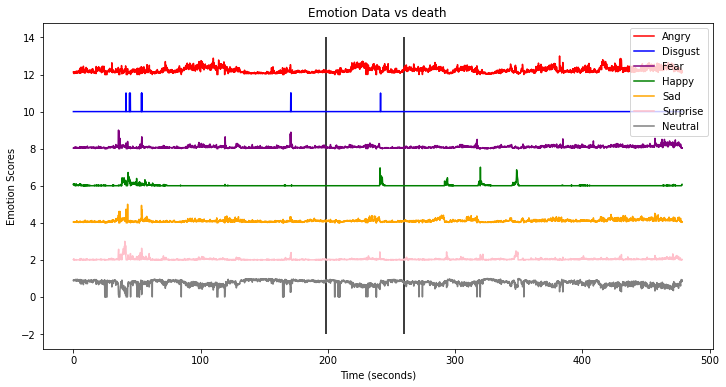

In [16]:
# Plot Emotion data against death
plt.figure(figsize=(12, 6))
plt.plot(emotion['Timestamp'], emotion['Angry']/max(abs(emotion['Angry']))+12, label='Angry', color='red')
plt.plot(emotion['Timestamp'], emotion['Disgust']/max(abs(emotion['Disgust']))+10, label='Disgust', color='blue')
plt.plot(emotion['Timestamp'], emotion['Fear']/max(abs(emotion['Fear']))+8, label='Fear', color='purple')
plt.plot(emotion['Timestamp'], emotion['Happy']/max(abs(emotion['Happy']))+6, label='Happy', color='green')
plt.plot(emotion['Timestamp'], emotion['Sad']/max(abs(emotion['Sad']))+4, label='Sad', color='orange')
plt.plot(emotion['Timestamp'], emotion['Surprise']/max(abs(emotion['Surprise']))+2, label='Surprise', color='pink')
plt.plot(emotion['Timestamp'], emotion['Neutral']/max(abs(emotion['Neutral'])), label='Neutral', color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Emotion Scores', color='black')
plt.title('Emotion Data vs death')
plt.legend(loc='upper right')

# Plot vertical lines for kills
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        plt.vlines(timestamp, -2, 14, colors='black')

plt.show()
plt.close()

In [17]:
keyboard['Timestamp'] = (keyboard['Timestamp'] - keyboard['Timestamp'].min()).dt.total_seconds()

In [18]:
keyboard

,Timestamp,Mouse Position,Input,Type,X_Value,Y_Value
0,0.00,"Point(x=1756, y=603)",Button.left,Mouse Click,1756,603
1,0.10,"Point(x=1756, y=603)",Button.left,Mouse Click,1756,603
2,0.37,"Point(x=1280, y=720)",Key.alt_l,Key Press,1280,720
3,0.41,"Point(x=1280, y=720)",Key.tab,Key Press,1280,720
4,1.33,"Point(x=1169, y=586)",Button.left,Mouse Click,1169,586
...,...,...,...,...,...,...
2847,468.21,"Point(x=1280, y=715)",Key.tab,Key Press,1280,715
2848,470.14,"Point(x=1280, y=720)",Key.alt_l,Key Press,1280,720
2849,470.20,"Point(x=1280, y=720)",Key.tab,Key Press,1280,720
2850,471.02,"Point(x=1803, y=827)",Button.left,Mouse Click,1803,827


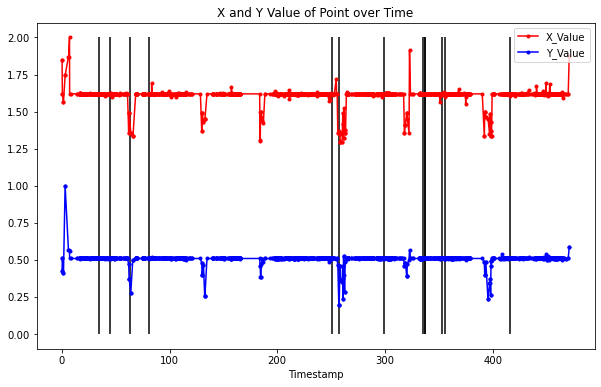

In [19]:
# Plot activity data against kill
plt.figure(figsize=(10, 6))
plt.plot(keyboard['Timestamp'], keyboard['X_Value']/max(abs(keyboard['X_Value']))+1, marker='.', linestyle='-', color='red', label='X_Value')
plt.plot(keyboard['Timestamp'], keyboard['Y_Value']/max(abs(keyboard['Y_Value'])), marker='.', linestyle='-', color='blue', label='Y_Value')

# Customize the plot
plt.xlabel('Timestamp')
plt.title('X and Y Value of Point over Time')

#date_form = mdates.DateFormatter("%H:%M:%S")
#plt.gca().xaxis.set_major_formatter(date_form)

# Plot vertical lines for kills
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        plt.vlines(timestamp, 0, 2, colors='black')

plt.legend(loc='upper right')

# Display the plot
plt.show()
plt.close()

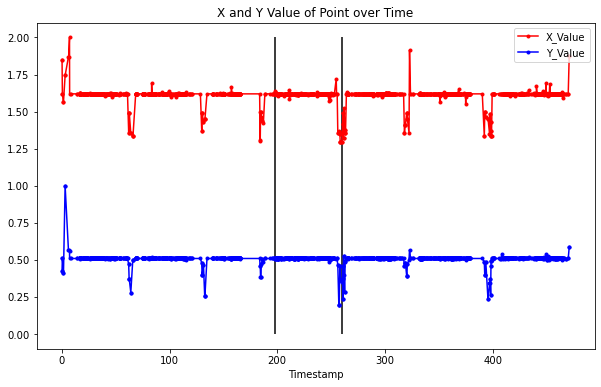

In [20]:
# Plot activity data against death
plt.figure(figsize=(10, 6))
plt.plot(keyboard['Timestamp'], keyboard['X_Value']/max(abs(keyboard['X_Value']))+1, marker='.', linestyle='-', color='red', label='X_Value')
plt.plot(keyboard['Timestamp'], keyboard['Y_Value']/max(abs(keyboard['Y_Value'])), marker='.', linestyle='-', color='blue', label='Y_Value')

# Customize the plot
plt.xlabel('Timestamp')
plt.title('X and Y Value of Point over Time')

#date_form = mdates.DateFormatter("%H:%M:%S")
#plt.gca().xaxis.set_major_formatter(date_form)

# Plot vertical lines for kills
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        plt.vlines(timestamp, 0, 2, colors='black')

plt.legend(loc='upper right')

# Display the plot
plt.show()
plt.close()

# Kill Graph

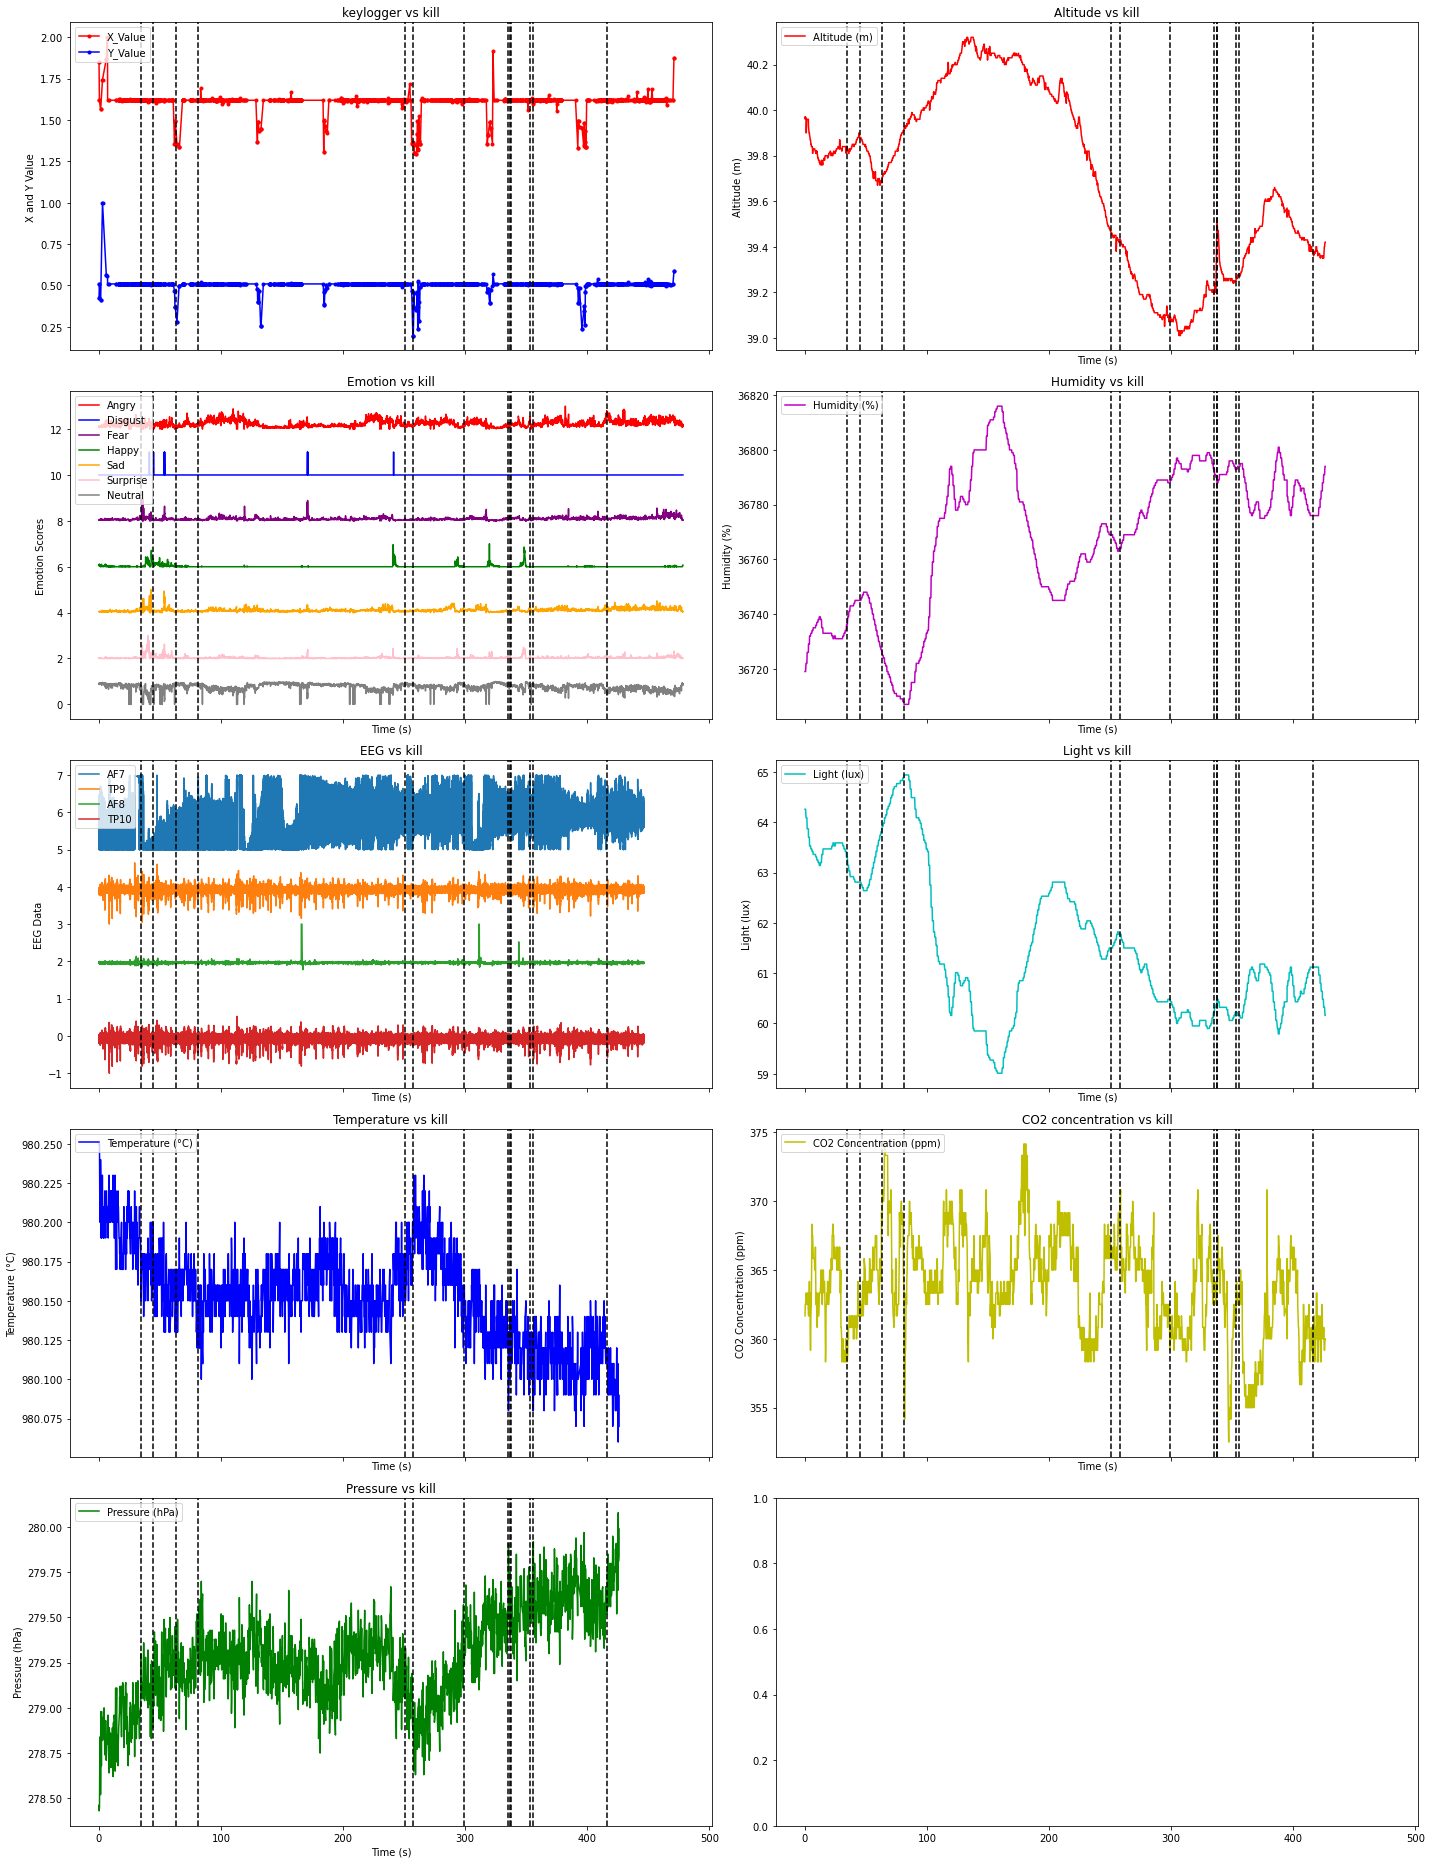

In [29]:
# Overall against kill
# Create a figure with two subplots sharing the x-axis
fig, axs = plt.subplots(5, 2, figsize=(20, 26), sharex=True)

# Plot activity data against kill on the first subplot
axs[0,0].plot(keyboard['Timestamp'], keyboard['X_Value']/max(abs(keyboard['X_Value']))+1, marker='.', linestyle='-', color='red', label='X_Value')
axs[0,0].plot(keyboard['Timestamp'], keyboard['Y_Value']/max(abs(keyboard['Y_Value'])), marker='.', linestyle='-', color='blue', label='Y_Value')
axs[1,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('X and Y Value', color='black')
axs[0,0].legend(loc='upper left')
axs[0,0].set_title('keylogger vs kill')

# Plot vertical lines for kills on the first subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[0,0].axvline(timestamp, 0, 2, color='black',linestyle='--')

# Plot Emotion data against kills on the second subplot
axs[1,0].plot(emotion['Timestamp'], emotion['Angry']/max(abs(emotion['Angry']))+12, label='Angry', color='red')
axs[1,0].plot(emotion['Timestamp'], emotion['Disgust']/max(abs(emotion['Disgust']))+10, label='Disgust', color='blue')
axs[1,0].plot(emotion['Timestamp'], emotion['Fear']/max(abs(emotion['Fear']))+8, label='Fear', color='purple')
axs[1,0].plot(emotion['Timestamp'], emotion['Happy']/max(abs(emotion['Happy']))+6, label='Happy', color='green')
axs[1,0].plot(emotion['Timestamp'], emotion['Sad']/max(abs(emotion['Sad']))+4, label='Sad', color='orange')
axs[1,0].plot(emotion['Timestamp'], emotion['Surprise']/max(abs(emotion['Surprise']))+2, label='Surprise', color='pink')
axs[1,0].plot(emotion['Timestamp'], emotion['Neutral']/max(abs(emotion['Neutral'])), label='Neutral', color='gray')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Emotion Scores', color='black')
axs[1,0].legend(loc='upper left')
axs[1,0].set_title("Emotion vs kill")

# Plot vertical lines for kills on the second subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[1,0].axvline(timestamp, 0, 2, color='black',linestyle='--')

# EEG against kills on the third subplot
y_tp9 = eeg['TP9']
y_af7 = eeg['AF7']
y_af8 = eeg['AF8']
y_tp10 = eeg['TP10']
axs[2,0].plot(eeg['timestamps_alt'], y_af7/max(abs(y_af7)) + 6, label='AF7')
axs[2,0].plot(eeg['timestamps_alt'], y_tp9/max(abs(y_tp9)) + 4, label='TP9')
axs[2,0].plot(eeg['timestamps_alt'], y_af8/max(abs(y_af8)) + 2, label='AF8')
axs[2,0].plot(eeg['timestamps_alt'], y_tp10/max(abs(y_tp10)), label='TP10')
axs[2,0].set_xlabel('Time (s)')
axs[2,0].set_ylabel('EEG Data', color='black')
axs[2,0].legend(loc='upper left')
axs[2,0].set_title("EEG vs kill")

# Plot vertical lines for kills on the third subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[2,0].axvline(timestamp, 0, 2, color='black',linestyle='--')

# Temperature against kills on the forth subplot
axs[3, 0].plot(time_values_in_seconds, temperature_values, 'b-', label='Temperature (°C)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[3,0].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylabel('Temperature (°C)')
axs[3, 0].legend(loc='upper left')
axs[3, 0].set_title("Temperature vs kill")

# Pressure against kills on the fifth subplot
axs[4, 0].plot(time_values_in_seconds, pressure_values, 'g-', label='Pressure (hPa)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[4,0].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[4, 0].set_xlabel('Time (s)')
axs[4, 0].set_ylabel('Pressure (hPa)')
axs[4, 0].legend(loc='upper left')
axs[4, 0].set_title("Pressure vs kill")

# Altitude against kills on the sixth subplot
axs[0, 1].plot(time_values_in_seconds, altitude_values, 'r-', label='Altitude (m)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[0,1].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Altitude (m)')
axs[0, 1].legend(loc='upper left')
axs[0, 1].set_title("Altitude vs kill")

# Humidity against kills on the seventh subplot
axs[1, 1].plot(time_values_in_seconds, humidity_values, 'm-', label='Humidity (%)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[1,1].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Humidity (%)')
axs[1, 1].legend(loc='upper left')
axs[1, 1].set_title("Humidity vs kill")

# Light against kills on the eighth subplot
axs[2, 1].plot(time_values_in_seconds, light_values, 'c-', label='Light (lux)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[2,1].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Light (lux)')
axs[2, 1].legend(loc='upper left')
axs[2, 1].set_title("Light vs kill")

# CO2 concentration against kills on the nineth subplot
axs[3, 1].plot(time_values_in_seconds, co2_values, 'y-', label='CO2 Concentration (ppm)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[3,1].axvline(timestamp, 0, 2, color='black',linestyle='--')
axs[3, 1].set_xlabel('Time (s)')
axs[3, 1].set_ylabel('CO2 Concentration (ppm)')
axs[3, 1].legend(loc='upper left')
axs[3, 1].set_title("CO2 concentration vs kill")

# Adjust layout and display the plot
fig.tight_layout()
fig.savefig("Overal kill Graph.png")
plt.show()
plt.close(fig)

# Death Graph


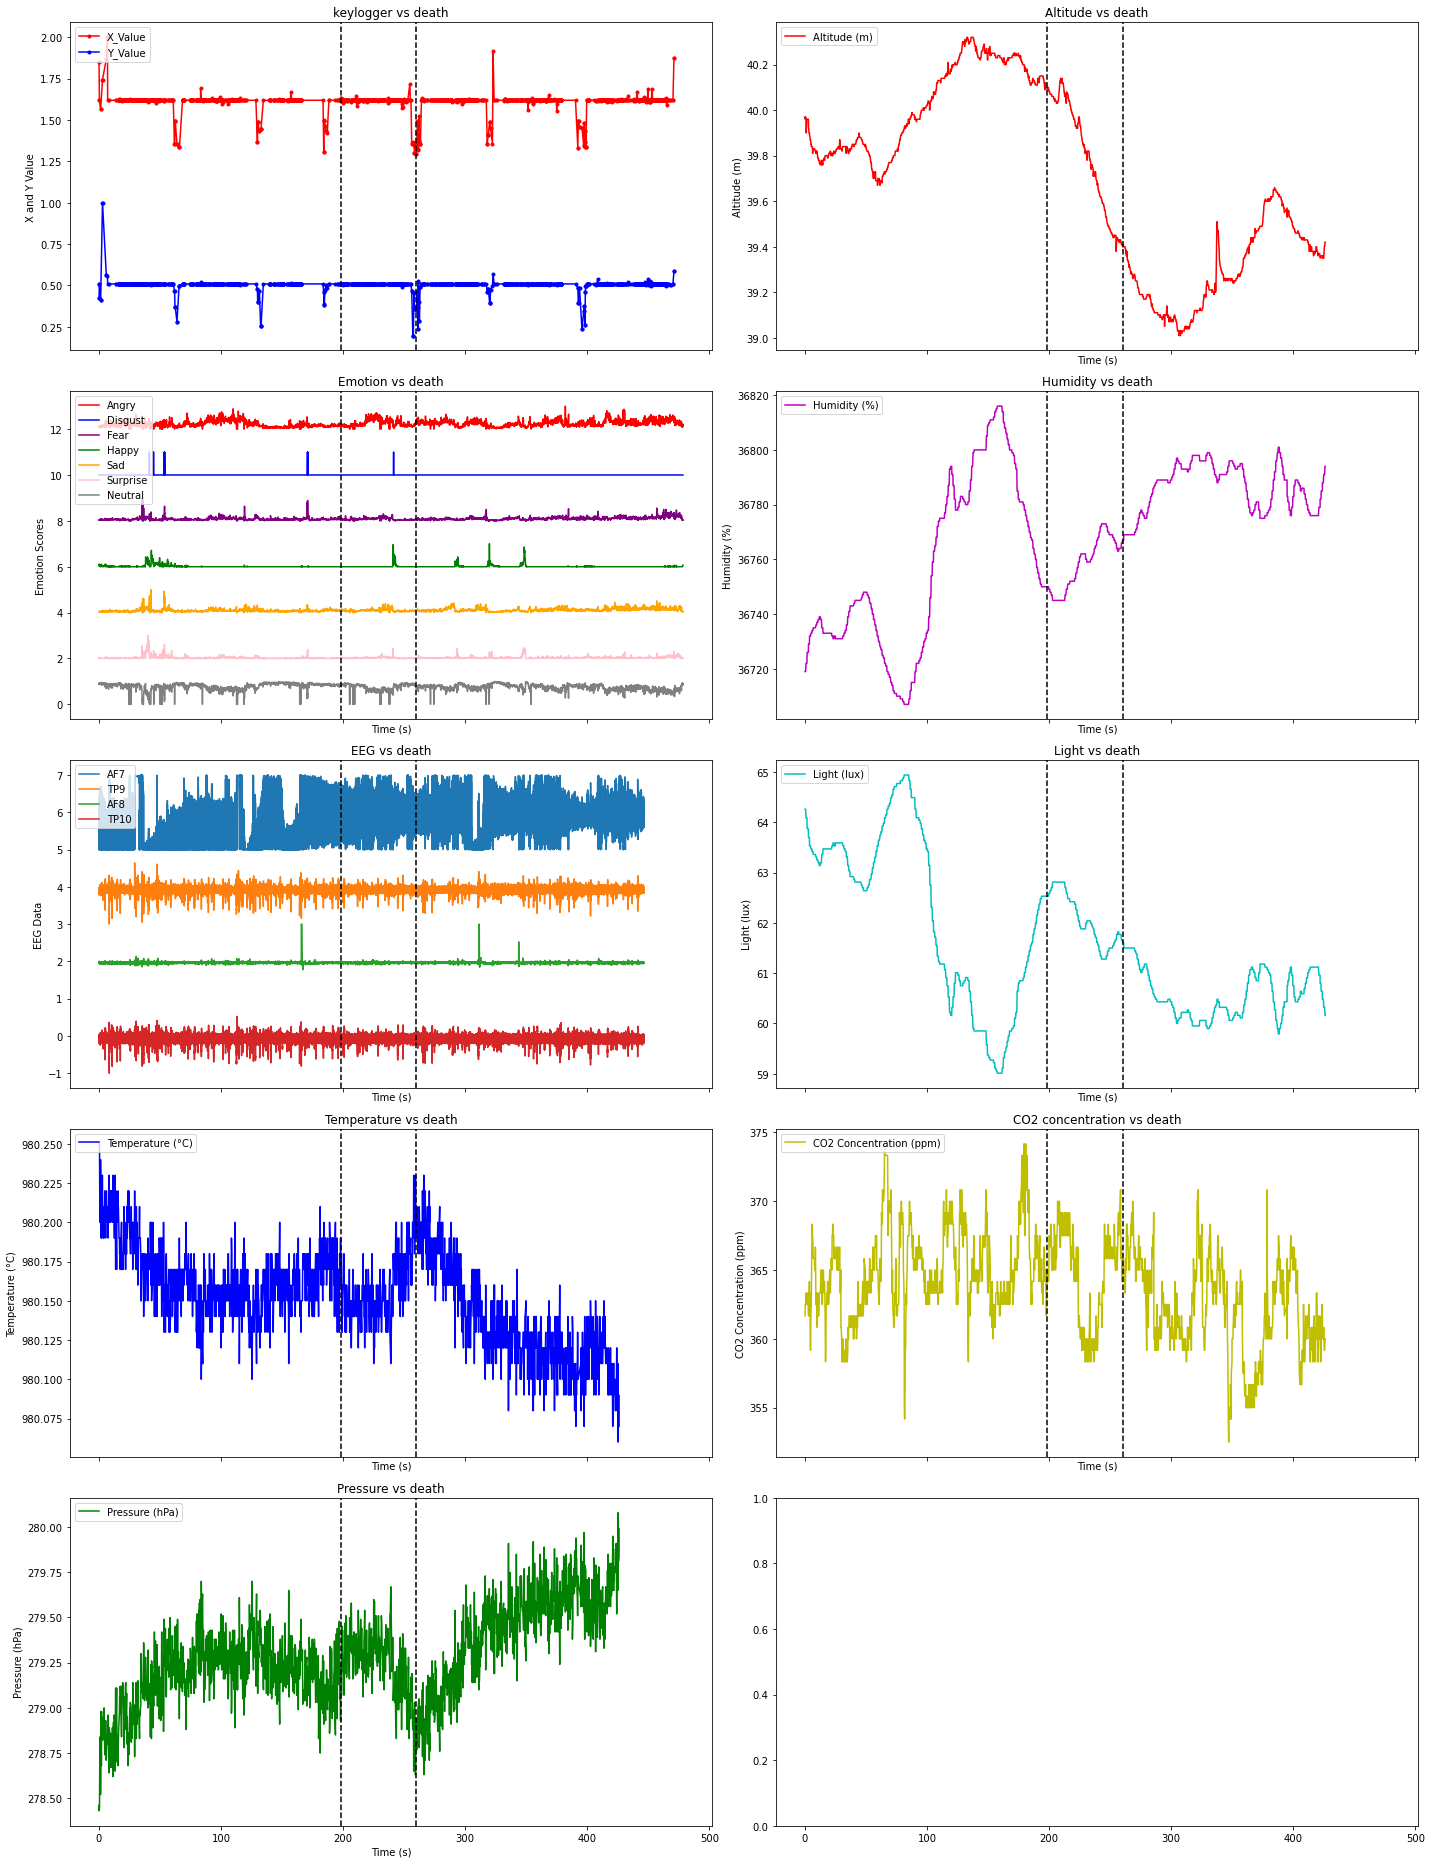

In [30]:
# Overall against death
# Create a figure with two subplots sharing the x-axis
fig, axs = plt.subplots(5, 2, figsize=(20, 26), sharex=True)

# Plot activity data against death on the first subplot
axs[0,0].plot(keyboard['Timestamp'], keyboard['X_Value']/max(abs(keyboard['X_Value']))+1, marker='.', linestyle='-', color='red', label='X_Value')
axs[0,0].plot(keyboard['Timestamp'], keyboard['Y_Value']/max(abs(keyboard['Y_Value'])), marker='.', linestyle='-', color='blue', label='Y_Value')
axs[1,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('X and Y Value', color='black')
axs[0,0].legend(loc='upper left')
axs[0,0].set_title('keylogger vs death')

# Plot vertical lines for deaths on the first subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[0,0].axvline(timestamp, color='black', linestyle='--')

# Plot Emotion data against death on the second subplot
axs[1,0].plot(emotion['Timestamp'], emotion['Angry']/max(abs(emotion['Angry']))+12, label='Angry', color='red')
axs[1,0].plot(emotion['Timestamp'], emotion['Disgust']/max(abs(emotion['Disgust']))+10, label='Disgust', color='blue')
axs[1,0].plot(emotion['Timestamp'], emotion['Fear']/max(abs(emotion['Fear']))+8, label='Fear', color='purple')
axs[1,0].plot(emotion['Timestamp'], emotion['Happy']/max(abs(emotion['Happy']))+6, label='Happy', color='green')
axs[1,0].plot(emotion['Timestamp'], emotion['Sad']/max(abs(emotion['Sad']))+4, label='Sad', color='orange')
axs[1,0].plot(emotion['Timestamp'], emotion['Surprise']/max(abs(emotion['Surprise']))+2, label='Surprise', color='pink')
axs[1,0].plot(emotion['Timestamp'], emotion['Neutral']/max(abs(emotion['Neutral'])), label='Neutral', color='gray')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Emotion Scores', color='black')
axs[1,0].legend(loc='upper left')
axs[1,0].set_title("Emotion vs death")

# Plot vertical lines for deaths on the second subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[1,0].axvline(timestamp, color='black', linestyle='--')

# EEG against death on the third subplot
y_tp9 = eeg['TP9']
y_af7 = eeg['AF7']
y_af8 = eeg['AF8']
y_tp10 = eeg['TP10']
axs[2,0].plot(eeg['timestamps_alt'], y_af7/max(abs(y_af7)) + 6, label='AF7')
axs[2,0].plot(eeg['timestamps_alt'], y_tp9/max(abs(y_tp9)) + 4, label='TP9')
axs[2,0].plot(eeg['timestamps_alt'], y_af8/max(abs(y_af8)) + 2, label='AF8')
axs[2,0].plot(eeg['timestamps_alt'], y_tp10/max(abs(y_tp10)), label='TP10')
axs[2,0].set_xlabel('Time (s)')
axs[2,0].set_ylabel('EEG Data', color='black')
axs[2,0].legend(loc='upper left')
axs[2,0].set_title("EEG vs death")

# Plot vertical lines for kills on the third subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[2,0].axvline(timestamp, color='black', linestyle='--')

# Temperature against death on the forth subplot
axs[3, 0].plot(time_values_in_seconds, temperature_values, 'b-', label='Temperature (°C)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[3,0].axvline(timestamp, color='black', linestyle='--')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylabel('Temperature (°C)')
axs[3, 0].legend(loc='upper left')
axs[3, 0].set_title("Temperature vs death")

# Pressure against death on the fifth subplot
axs[4, 0].plot(time_values_in_seconds, pressure_values, 'g-', label='Pressure (hPa)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[4,0].axvline(timestamp, color='black', linestyle='--')
axs[4, 0].set_xlabel('Time (s)')
axs[4, 0].set_ylabel('Pressure (hPa)')
axs[4, 0].legend(loc='upper left')
axs[4, 0].set_title("Pressure vs death")

# Altitude against death on the sixth subplot
axs[0, 1].plot(time_values_in_seconds, altitude_values, 'r-', label='Altitude (m)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[0,1].axvline(timestamp, color='black', linestyle='--')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Altitude (m)')
axs[0, 1].legend(loc='upper left')
axs[0, 1].set_title("Altitude vs death")

# Humidity against death on the seventh subplot
axs[1, 1].plot(time_values_in_seconds, humidity_values, 'm-', label='Humidity (%)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[1,1].axvline(timestamp, color='black', linestyle='--')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Humidity (%)')
axs[1, 1].legend(loc='upper left')
axs[1, 1].set_title("Humidity vs death")

# Light against death on the eighth subplot
axs[2, 1].plot(time_values_in_seconds, light_values, 'c-', label='Light (lux)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[2,1].axvline(timestamp, color='black', linestyle='--')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Light (lux)')
axs[2, 1].legend(loc='upper left')
axs[2, 1].set_title("Light vs death")

# CO2 concentration against death on the nineth subplot
axs[3, 1].plot(time_values_in_seconds, co2_values, 'y-', label='CO2 Concentration (ppm)')
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[3,1].axvline(timestamp, color='black', linestyle='--')
axs[3, 1].set_xlabel('Time (s)')
axs[3, 1].set_ylabel('CO2 Concentration (ppm)')
axs[3, 1].legend(loc='upper left')
axs[3, 1].set_title("CO2 concentration vs death")

# Adjust layout and display the plot
fig.tight_layout()
fig.savefig("Overal Death Graph.png")
plt.show()
plt.close(fig)

# Death and Kill Together

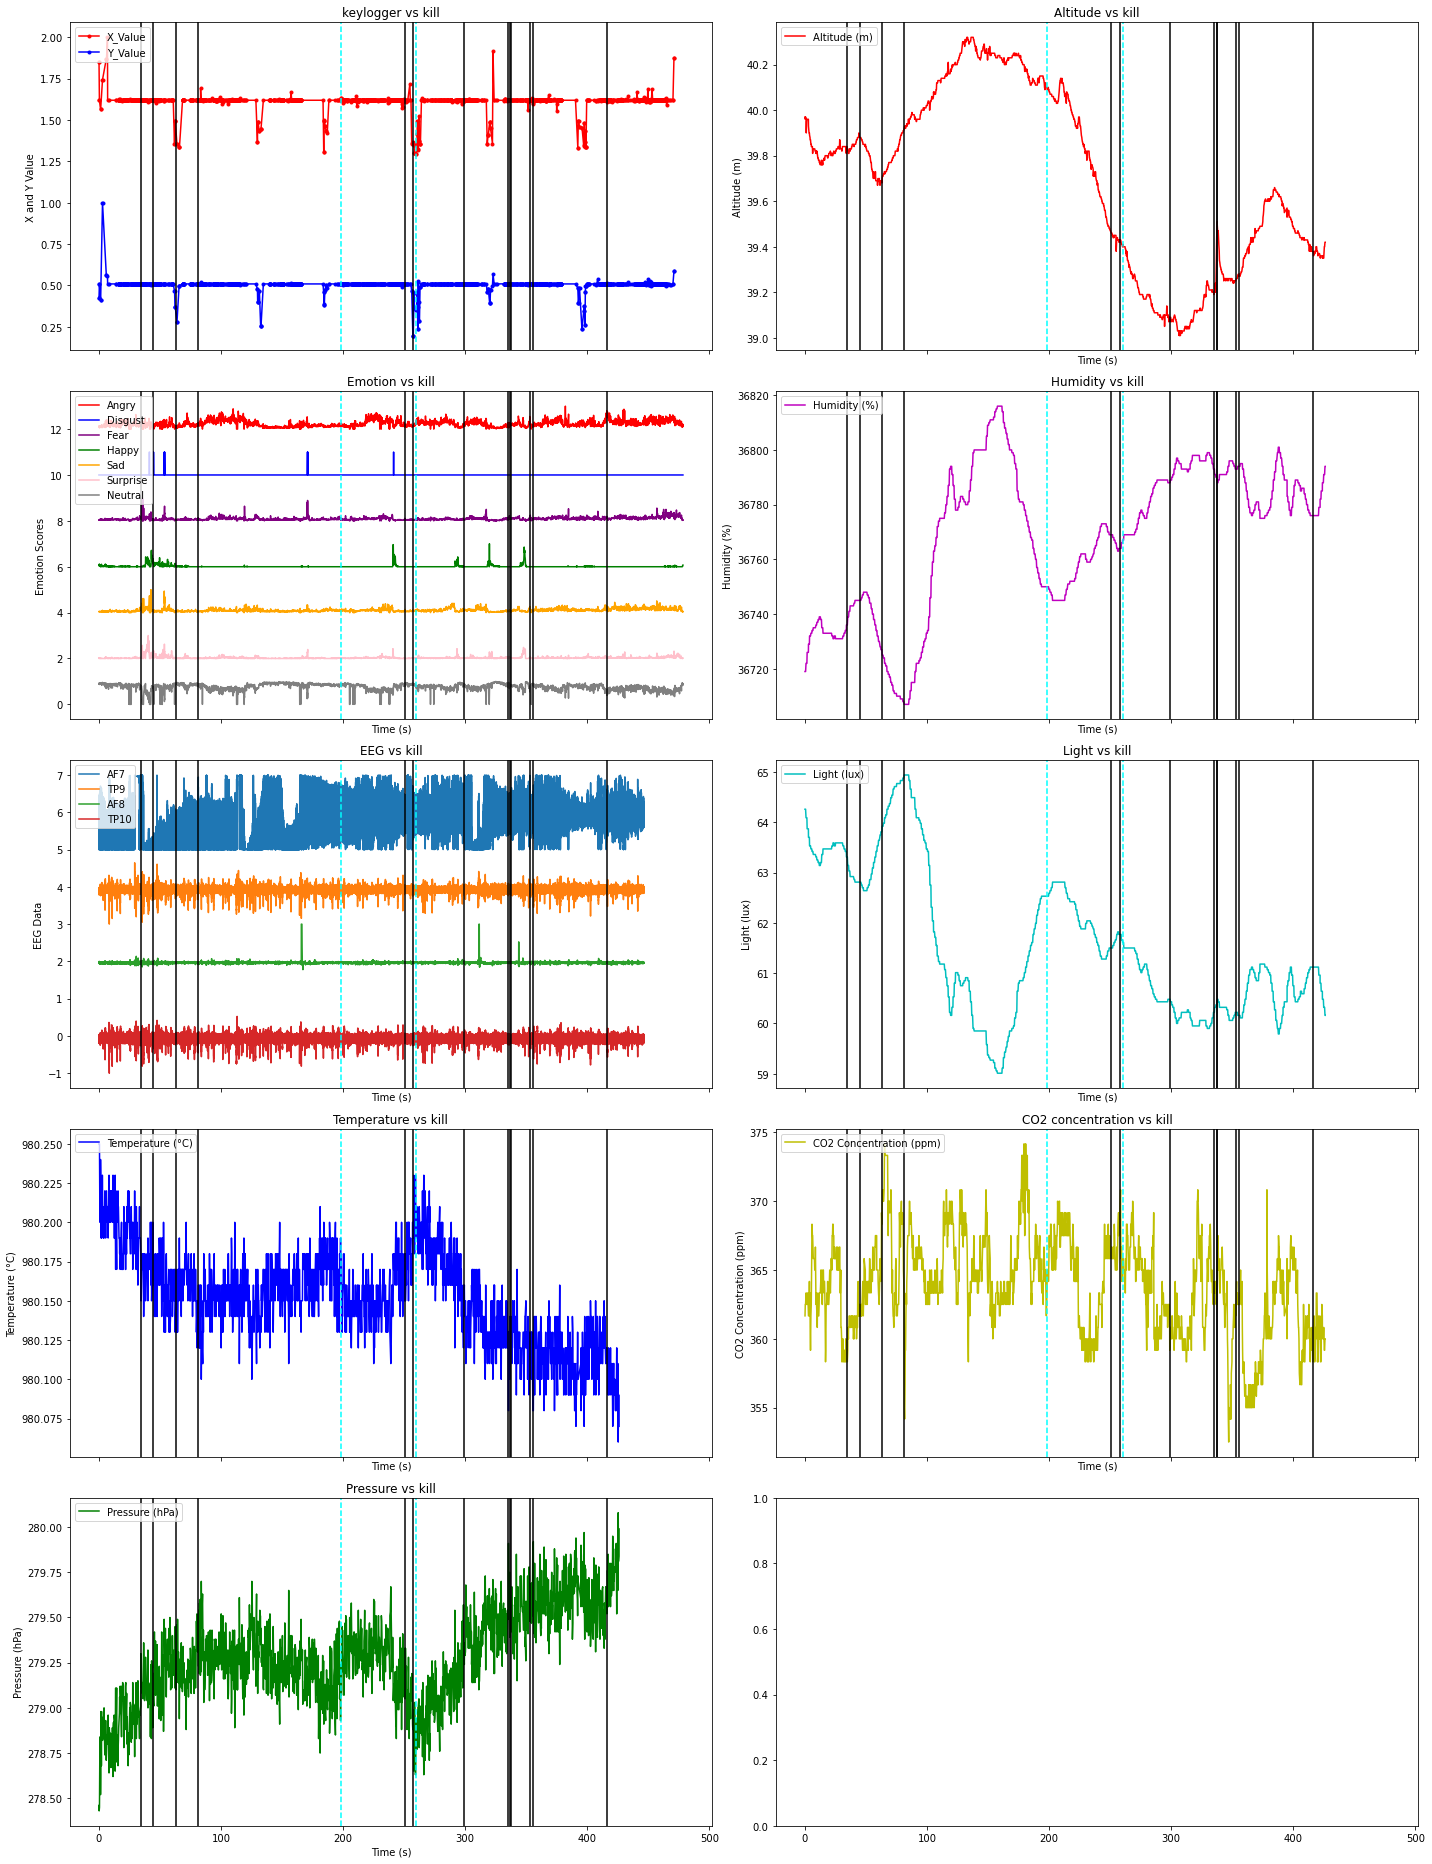

In [31]:
# Overall against kill
# Create a figure with two subplots sharing the x-axis
fig, axs = plt.subplots(5, 2, figsize=(20, 26), sharex=True)
# Plot activity data against kill on the first subplot
axs[0,0].plot(keyboard['Timestamp'], keyboard['X_Value']/max(abs(keyboard['X_Value']))+1, marker='.', linestyle='-', color='red', label='X_Value')
axs[0,0].plot(keyboard['Timestamp'], keyboard['Y_Value']/max(abs(keyboard['Y_Value'])), marker='.', linestyle='-', color='blue', label='Y_Value')
axs[1,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('X and Y Value', color='black')
axs[0,0].legend(loc='upper left')
axs[0,0].set_title('keylogger vs kill')

# Plot vertical lines for kills on the first subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[0,0].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the first subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[0,0].axvline(timestamp, color='cyan', linestyle='--')
# Plot Emotion data against kills on the second subplot
axs[1,0].plot(emotion['Timestamp'], emotion['Angry']/max(abs(emotion['Angry']))+12, label='Angry', color='red')
axs[1,0].plot(emotion['Timestamp'], emotion['Disgust']/max(abs(emotion['Disgust']))+10, label='Disgust', color='blue')
axs[1,0].plot(emotion['Timestamp'], emotion['Fear']/max(abs(emotion['Fear']))+8, label='Fear', color='purple')
axs[1,0].plot(emotion['Timestamp'], emotion['Happy']/max(abs(emotion['Happy']))+6, label='Happy', color='green')
axs[1,0].plot(emotion['Timestamp'], emotion['Sad']/max(abs(emotion['Sad']))+4, label='Sad', color='orange')
axs[1,0].plot(emotion['Timestamp'], emotion['Surprise']/max(abs(emotion['Surprise']))+2, label='Surprise', color='pink')
axs[1,0].plot(emotion['Timestamp'], emotion['Neutral']/max(abs(emotion['Neutral'])), label='Neutral', color='gray')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Emotion Scores', color='black')
axs[1,0].legend(loc='upper left')
axs[1,0].set_title("Emotion vs kill")

# Plot vertical lines for kills on the second subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[1,0].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the second subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[1,0].axvline(timestamp, color='cyan', linestyle='--')
# EEG against kills on the third subplot
y_tp9 = eeg['TP9']
y_af7 = eeg['AF7']
y_af8 = eeg['AF8']
y_tp10 = eeg['TP10']
axs[2,0].plot(eeg['timestamps_alt'], y_af7/max(abs(y_af7)) + 6, label='AF7')
axs[2,0].plot(eeg['timestamps_alt'], y_tp9/max(abs(y_tp9)) + 4, label='TP9')
axs[2,0].plot(eeg['timestamps_alt'], y_af8/max(abs(y_af8)) + 2, label='AF8')
axs[2,0].plot(eeg['timestamps_alt'], y_tp10/max(abs(y_tp10)), label='TP10')
axs[2,0].set_xlabel('Time (s)')
axs[2,0].set_ylabel('EEG Data', color='black')
axs[2,0].legend(loc='upper left')
axs[2,0].set_title("EEG vs kill")

# Plot vertical lines for kills on the third subplot
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[2,0].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the third subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[2,0].axvline(timestamp, color='cyan', linestyle='--')
# Temperature against kills on the forth subplot
axs[3, 0].plot(time_values_in_seconds, temperature_values, 'b-', label='Temperature (°C)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[3,0].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the forth subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[3,0].axvline(timestamp, color='cyan', linestyle='--')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylabel('Temperature (°C)')
axs[3, 0].legend(loc='upper left')
axs[3, 0].set_title("Temperature vs kill")

# Pressure against kills on the fifth subplot
axs[4, 0].plot(time_values_in_seconds, pressure_values, 'g-', label='Pressure (hPa)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[4,0].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the fifth subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[4,0].axvline(timestamp, color='cyan', linestyle='--')
axs[4, 0].set_xlabel('Time (s)')
axs[4, 0].set_ylabel('Pressure (hPa)')
axs[4, 0].legend(loc='upper left')
axs[4, 0].set_title("Pressure vs kill")

# Altitude against kills on the sixth subplot
axs[0, 1].plot(time_values_in_seconds, altitude_values, 'r-', label='Altitude (m)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[0,1].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the sixth subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[0,1].axvline(timestamp, color='cyan', linestyle='--')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Altitude (m)')
axs[0, 1].legend(loc='upper left')
axs[0, 1].set_title("Altitude vs kill")

# Humidity against kills on the seventh subplot
axs[1, 1].plot(time_values_in_seconds, humidity_values, 'm-', label='Humidity (%)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[1,1].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the seventh subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[1,1].axvline(timestamp, color='cyan', linestyle='--')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Humidity (%)')
axs[1, 1].legend(loc='upper left')
axs[1, 1].set_title("Humidity vs kill")

# Light against kills on the eighth subplot
axs[2, 1].plot(time_values_in_seconds, light_values, 'c-', label='Light (lux)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[2,1].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the eighth subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[2,1].axvline(timestamp, color='cyan', linestyle='--')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Light (lux)')
axs[2, 1].legend(loc='upper left')
axs[2, 1].set_title("Light vs kill")

# CO2 concentration against kills on the nineth subplot
axs[3, 1].plot(time_values_in_seconds, co2_values, 'y-', label='CO2 Concentration (ppm)')
for timestamp, kill in zip(kill_df['Timestamp'], kill_df['Kills']):
    if kill == 1:
        axs[3,1].axvline(timestamp, 0, 2, color='black',linestyle='-')
# Plot vertical lines for deaths on the nineth subplot
for timestamp, death in zip(death_df['Timestamp'], death_df['Death']):
    if death == 1:
        axs[3,1].axvline(timestamp, color='cyan', linestyle='--')
axs[3, 1].set_xlabel('Time (s)')
axs[3, 1].set_ylabel('CO2 Concentration (ppm)')
axs[3, 1].legend(loc='upper left')
axs[3, 1].set_title("CO2 concentration vs kill")
fig.tight_layout()
plt.show()
fig.savefig("Overal Graph.png")
plt.close(fig)